In [9]:
import ee
import pandas as pd
from prophet import Prophet

# Earth Engine API 초기화
ee.Initialize()

# GeoJSON 구조를 사용하여 AOI 설정
aoi = ee.Geometry.Polygon(
    [[[126.19653266055587, 36.853168924185226],
      [126.19653266055587, 36.83836240145186],
      [126.21259510596076, 36.83836240145186],
      [126.21259510596076, 36.853168924185226],
      [126.19653266055587, 36.853168924185226]]]
)

start_date = '2013-01-01'
end_date = '2023-10-31'

# GeoJSON 구조를 사용하여 AOI 설정
def create_ee_polygon_from_geojson(gjson):
    # GeoJSON의 coordinates 부분 추출
    coordinates = gjson['geometry']['coordinates']

    # 추출된 좌표를 이용하여 ee.Geometry.Polygon 객체 생성
    aoi = ee.Geometry.Polygon(coordinates)
    return aoi

def calculateRVI(aoi,start_date,end_date):
    # Sentinel-1 ImageCollection 필터링
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(aoi) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

    # RVI 계산 및 시계열 데이터 생성 함수
    def calculate_rvi(image):
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        vv = image.select('VV')
        vh = image.select('VH')
        rvi = vh.multiply(4).divide(vv.add(vh))
        mean_rvi = rvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=10
        ).get('VH')
        return ee.Feature(None, {'ds': date, 'y': mean_rvi})

    # 시계열 RVI 계산
    time_series_rvi = sentinel1.map(calculate_rvi)

    # 결과를 서버측 객체로 변환 (Python 클라이언트로 가져오기 위함)
    rvi_features = time_series_rvi.getInfo()['features']

    # 결과를 pandas DataFrame으로 변환
    df = pd.DataFrame([feat['properties'] for feat in rvi_features])

    # DataFrame을 'Date' 컬럼에 따라 오름차순으로 정렬
    df = df.sort_values(by='ds')
    return df

In [10]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

In [11]:
sentinel1

In [12]:
def prophet_process(df):
    # Prophet 모델을 초기화하고 학습시킵니다.
    m = Prophet(yearly_seasonality=True,daily_seasonality=True)
    m.fit(df)

    # 미래 날짜 프레임을 만들고 예측을 진행합니다.
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future) 

    # 예측 결과를 가져옵니다.
    forecasted_value = forecast.iloc[-1]['yhat']  # 예측된 값을 가져옴
    print(f"Forecasted mean NDVI for the next period: {forecasted_value}")

    # 예측 결과를 데이터프레임에 추가합니다.
    forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)
    return forecast_df

In [14]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

df = calculateRVI(aoi,start_date,end_date)

In [15]:
df

,ds,y
0,2015-05-18,2.428871
1,2016-05-24,2.449276
2,2016-07-11,2.409288
3,2017-02-24,2.392519
4,2017-03-08,2.372436
...,...,...
184,2023-09-09,2.434097
185,2023-09-21,2.431516
186,2023-10-03,2.400269
187,2023-10-15,2.409676


In [19]:
def prophet_process(df):
    # Prophet 모델을 초기화하고 학습시킵니다.
    m = Prophet(yearly_seasonality=True)
    m.fit(df)

    # 미래 날짜 프레임을 만들고 예측을 진행합니다.
    future = m.make_future_dataframe(periods=1)
    forecast = m.predict(future)

    # 예측 결과를 가져옵니다.
    forecasted_value = forecast.iloc[-1]['yhat']  # 예측된 값을 가져옴
    print(f"Forecasted mean NDVI for the next period: {forecasted_value}")

    # 예측 결과를 데이터프레임에 추가합니다.
    forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)
    return forecast,forecast_df,df,m

In [20]:
forecast,forecast_df,df,m = prophet_process(df)

17:11:00 - cmdstanpy - INFO - Chain [1] start processing
17:11:00 - cmdstanpy - INFO - Chain [1] done processing


Forecasted mean NDVI for the next period: 2.405032768970864


C:\Users\gunwo\AppData\Local\Temp\ipykernel_32452\1245947043.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = df.append({'ds': future.iloc[-1]['ds'], 'y': forecasted_value}, ignore_index=True)


In [22]:
forecast.to_csv('sample.csv')

: 

In [8]:
df

,ds,y
0,2015-05-18,2.404320
1,2016-05-24,2.409713
2,2016-07-11,2.391706
3,2017-02-24,2.333741
4,2017-03-08,2.318668
...,...,...
184,2023-09-09,2.391171
185,2023-09-21,2.407438
186,2023-10-03,2.372393
187,2023-10-15,2.381215


In [9]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-05-18,2.347836,2.368445,2.414513,2.347836,2.347836,0.044237,0.044237,0.044237,0.001487,0.001487,0.001487,0.042750,0.042750,0.042750,0.0,0.0,0.0,2.392073
1,2016-05-24,2.350616,2.379268,2.426828,2.350616,2.350616,0.050845,0.050845,0.050845,0.000398,0.000398,0.000398,0.050447,0.050447,0.050447,0.0,0.0,0.0,2.401461
2,2016-07-11,2.350975,2.375636,2.424965,2.350975,2.350975,0.048688,0.048688,0.048688,0.001487,0.001487,0.001487,0.047201,0.047201,0.047201,0.0,0.0,0.0,2.399663
3,2017-02-24,2.352679,2.300412,2.348821,2.352679,2.352679,-0.028754,-0.028754,-0.028754,0.006394,0.006394,0.006394,-0.035149,-0.035149,-0.035149,0.0,0.0,0.0,2.323925
4,2017-03-08,2.352768,2.298837,2.347731,2.352768,2.352768,-0.027883,-0.027883,-0.027883,-0.003073,-0.003073,-0.003073,-0.024810,-0.024810,-0.024810,0.0,0.0,0.0,2.324886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,2024-10-22,2.407525,2.362368,2.412578,2.404361,2.410785,-0.021366,-0.021366,-0.021366,0.000398,0.000398,0.000398,-0.021764,-0.021764,-0.021764,0.0,0.0,0.0,2.386160
552,2024-10-23,2.407552,2.359443,2.408087,2.404369,2.410834,-0.024695,-0.024695,-0.024695,-0.003073,-0.003073,-0.003073,-0.021622,-0.021622,-0.021622,0.0,0.0,0.0,2.382857
553,2024-10-24,2.407578,2.356332,2.403508,2.404380,2.410880,-0.028950,-0.028950,-0.028950,-0.007495,-0.007495,-0.007495,-0.021456,-0.021456,-0.021456,0.0,0.0,0.0,2.378628
554,2024-10-25,2.407605,2.368798,2.415652,2.404390,2.410926,-0.014871,-0.014871,-0.014871,0.006394,0.006394,0.006394,-0.021265,-0.021265,-0.021265,0.0,0.0,0.0,2.392733


In [66]:


trend = forecast['trend']
weekly = forecast['weekly']
yearly = forecast['yearly']
ds = forecast['ds']

# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Plot the trend
fig.add_trace(go.Scatter(x=ds, y=trend, name='Trend'), row=1, col=1)

# Plot the weekly component
fig.add_trace(go.Scatter(x=ds, y=weekly, name='Weekly'), row=2, col=1)

# Plot the yearly component
fig.add_trace(go.Scatter(x=ds, y=yearly, name='Yearly'), row=3, col=1)

# Update layout if needed
fig.update_layout(title='Forecast Components')

# Show the plot
fig.show()

In [62]:
def plotly(df,forecast):
    fig = go.Figure()

    # 예측 그래프 추가
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='예측', mode='lines+markers'))

    # 관측치 추가 (원본 데이터셋을 사용)
    fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], name='관측치', mode='markers', marker=dict(color='red')))

    # 레이아웃 설정
    fig.update_layout(title='Prophet 예측 결과와 실제 관측값', xaxis_title='날짜', yaxis_title='값')

    # 그래프 표시
    fig.show()

In [65]:
import plotly.graph_objs as go
from prophet.plot import add_changepoints_to_plot

# Overall forecast plot
fig = go.Figure([
    go.Scatter(name='yhat', x=forecast['ds'], y=forecast['yhat'], mode='lines+markers',
               line=dict(color='blue')),
    go.Scatter(name='yhat_upper', x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', 
               line=dict(width=0)),
    go.Scatter(name='yhat_lower', x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', 
               line=dict(width=0)),
    go.Scatter(name='Actual', x=df['ds'], y=df['y'], mode='markers', marker=dict(color='black')),
    go.Scatter(name='Trend', x=forecast['ds'], y=forecast['trend'], mode='lines',
               line=dict(color='red')),
])

fig.update_traces(fill='tonexty') # Fill area between yhat_upper and yhat_lower

# Add changepoints
for changepoint in m.changepoints:
    fig.add_vline(x=changepoint, line_width=1, line_dash="dash", line_color="black")

fig.update_layout(title='Forecast with Changepoints', xaxis_title='Date', yaxis_title='y')

# Components plot (trend and yearly seasonality)
components_fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                               subplot_titles=('Trend', 'Yearly Seasonality'))

# Trend
components_fig.add_trace(go.Scatter(name='Trend', x=forecast['ds'], y=forecast['trend'], 
                                    mode='lines'), row=1, col=1)

# Yearly
components_fig.add_trace(go.Scatter(name='Yearly Seasonality', x=forecast['ds'], 
                                    y=forecast['yearly'], mode='lines'), row=2, col=1)

# Actual
components_fig.add_trace(go.Scatter(name='Actual', x=df['ds'], y=df['y'], mode='markers',
                                    marker=dict(color='black')), row=1, col=1)
components_fig.add_trace(go.Scatter(name='Actual', x=df['ds'], y=df['y'], mode='markers',
                                    marker=dict(color='black')), row=2, col=1)

components_fig.update_layout(title='Forecast Components')

# Show plots
fig.show()
components_fig.show()


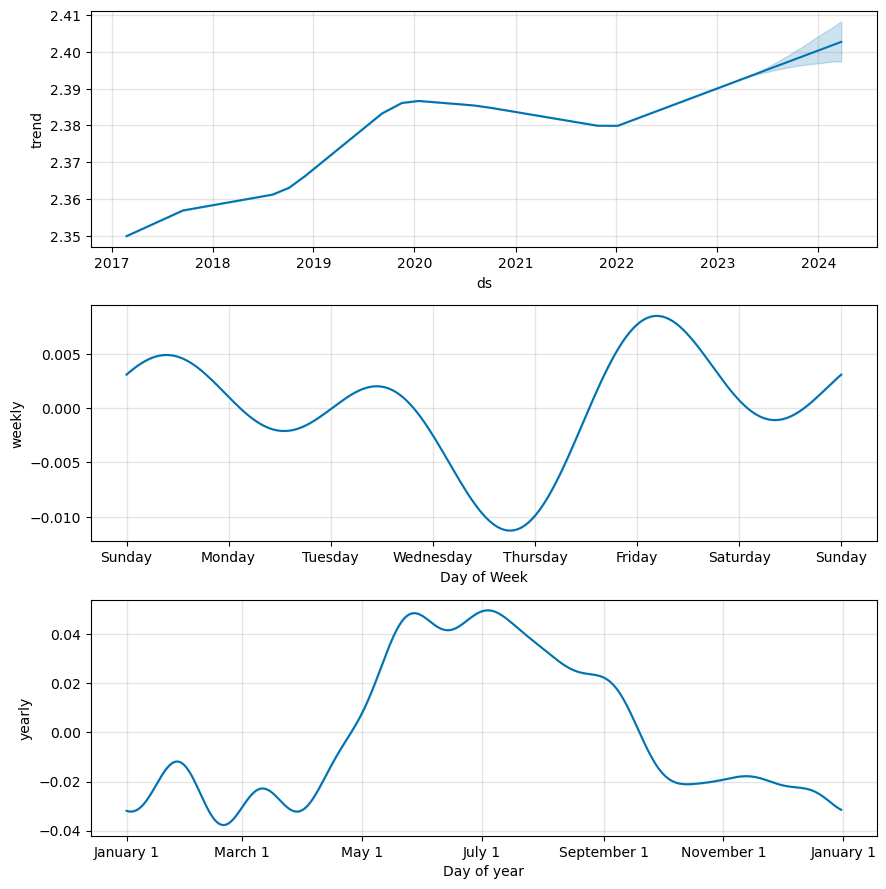

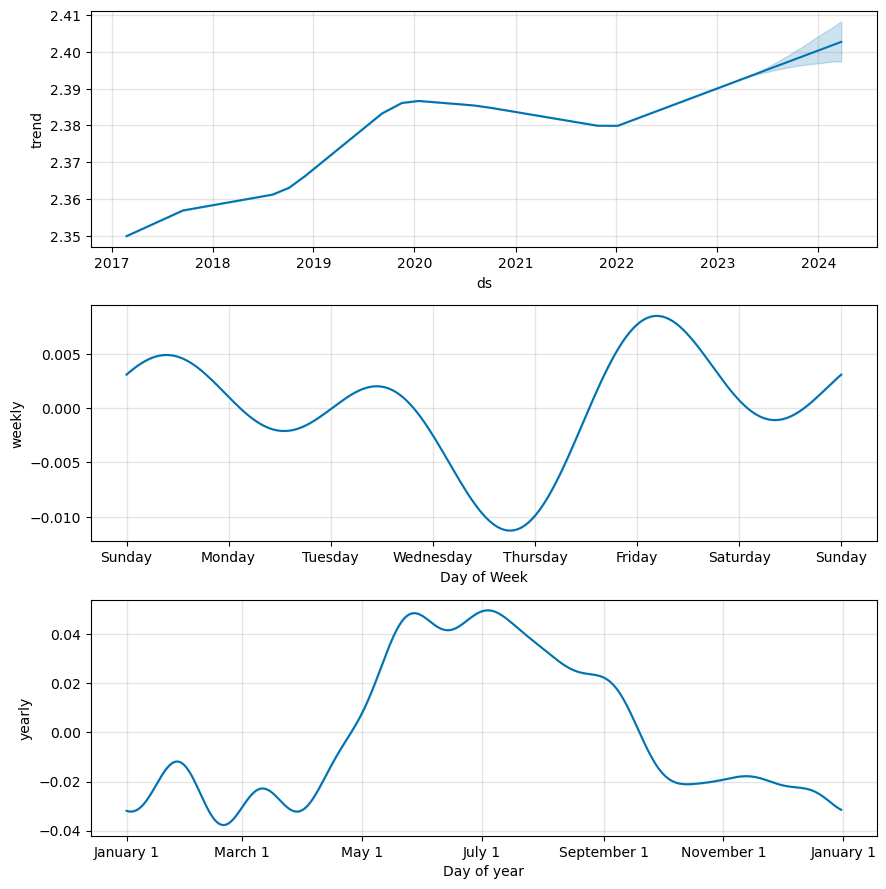

In [67]:
m.plot_components(forecast)



In [1]:
import geemap

In [2]:
map = geemap.Map()

In [16]:
roi = {
            "type": "Feature",
            "properties": {
                "name": "태안해안"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -233.942871,
                            36.330615
                        ],
                        [
                            -233.942871,
                            36.783992
                        ],
                        [
                            -233.514404,
                            36.783992
                        ],
                        [
                            -233.514404,
                            36.330615
                        ],
                        [
                            -233.942871,
                            36.330615
                        ]
                    ]
                ]
            }
        }

In [17]:
import geemap
import ee
ee.Initialize()

In [18]:

# GeoJSON 구조를 사용하여 AOI 설정
def create_ee_polygon_from_geojson(gjson):
    coordinates = gjson['geometry']['coordinates']
    aoi = ee.Geometry.Polygon(coordinates)
    return aoi


In [24]:
geemap.sentinel2_timelapse(
    roi=create_ee_polygon_from_geojson(roi),
    start_year = 2015,
    end_year = 2016,
    out_gif='output_gif.gif',
    frequency='month',
    bands=['Red', 'Green', 'Blue'],
        )

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\gunwo\github\Sar-Bluecarbon-Service\study\gunwoda\output_gif.gif


'c:\\Users\\gunwo\\github\\Sar-Bluecarbon-Service\\study\\gunwoda\\output_gif.gif'

In [8]:


# Sentinel-1 데이터를 가져옵니다.
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate('2019-01-01', '2019-12-31')
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
              .filter(ee.Filter.eq('instrumentMode', 'IW')))

# 첫 번째 이미지를 가져옵니다.
image = ee.Image(collection.first())

# True color로 이미지를 시각화합니다.
Map.addLayer(image, {
    'bands': ['VV', 'VH'],
    'min': [-25, -20],
    'max': [0, 10]
}, 'Sentinel-1')

# Map을 표시합니다.
Map

# Jupyter Notebook에서 Map을 표시하려면 다음을 실행합니다.
# Map.addLayerControl()
# Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [1]:
start_date = '2013-01-01'
end_date = '2023-10-31'

# GeoJSON 구조를 사용하여 AOI 설정
def create_ee_polygon_from_geojson(gjson):
    # GeoJSON의 coordinates 부분 추출
    coordinates = gjson['geometry']['coordinates']

    # 추출된 좌표를 이용하여 ee.Geometry.Polygon 객체 생성
    aoi = ee.Geometry.Polygon(coordinates)
    return aoi

In [12]:
import ee
import folium
ee.Initialize()

# 지역 및 날짜 설정
roi = {
            "type": "Feature",
            "properties": {
                "name": "태안해안"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -233.942871,
                            36.330615
                        ],
                        [
                            -233.942871,
                            36.783992
                        ],
                        [
                            -233.514404,
                            36.783992
                        ],
                        [
                            -233.514404,
                            36.330615
                        ],
                        [
                            -233.942871,
                            36.330615
                        ]
                    ]
                ]
            }
        }

# Sentinel-2 데이터 로드
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(create_ee_polygon_from_geojson(roi)) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
            .first()

# 밴드 선택
B02 = sentinel2.select('B2')  # Blue
B03 = sentinel2.select('B3')  # Green
B04 = sentinel2.select('B4')  # Red
B05 = sentinel2.select('B5')  # Red Edge
B08 = sentinel2.select('B8')  # NIR
B8A = sentinel2.select('B8A')  # Narrow NIR
B11 = sentinel2.select('B11')  # SWIR

print(B02)

# 수분 지수 및 NDWI 계산
moisture = B8A.subtract(B11).divide(B8A.add(B11))
NDWI = B03.subtract(B08).divide(B03.add(B08))
water_bodies = NDWI.subtract(moisture).divide(NDWI.add(moisture))

# 수생 식물 지수 계산
water_plants = B05.subtract(B04).divide(B05.add(B04))
NIR2 = B04.add(B11.subtract(B04))
FAI = B08.subtract(NIR2)

# 결과 시각화
visualization_parameters = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.3
}
Map = folium.Map()

# 수체 시각화
water_bodies_vis = water_bodies.updateMask(water_bodies.gt(0))
Map.addLayer(water_bodies_vis, visualization_parameters, 'Water Bodies')

# 수생 식물 시각화
water_plants_vis = water_plants.updateMask(water_plants.gt(0))
Map.addLayer(water_plants_vis, visualization_parameters, 'Water Plants')

# 조류 시각화
FAI_vis = FAI.updateMask(FAI.gt(0))
Map.addLayer(FAI_vis, visualization_parameters, 'Floating Algae Index (FAI)')

# 결과를 지도에 표시
Map.centerObject(create_ee_polygon_from_geojson(roi), 10)
Map.add_to


ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.select",
    "arguments": {
      "bandSelectors": {
        "constantValue": [
          "B2"
        ]
      },
      "input": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.filter",
                      "arguments": {
                        "collection": {
                          "functionInvocationValue": {
                            "functionName": "Collection.filter",
                            "arguments": {
                              "collection": {
                                "functionInvocationValue": {
                                  "functionName"

AttributeError: 'Map' object has no attribute 'addLayer'

In [14]:
import ee
import pandas as pd
from prophet import Prophet
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Initialize the Earth Engine API.
ee.Initialize()

# Define the AOI and date range.
aoi = ee.Geometry.Polygon(
    [[[126.19653266055587, 36.853168924185226],
      [126.19653266055587, 36.83836240145186],
      [126.21259510596076, 36.83836240145186],
      [126.21259510596076, 36.853168924185226]]]
)
start_date = '2020-01-01'
end_date = '2020-03-31'

# Import geetools for cloud masking.
from geetools import cloud_mask

# Function to calculate monthly NDVI using Sentinel-2 with cloud masking.
def calculate_monthly_ndvi(aoi, start_date, end_date):
    def mask_s2_clouds(image):
        return cloud_mask.sentinel2()(image)

    sentinel2 = (ee.ImageCollection('COPERNICUS/S2')
                 .filterBounds(aoi)
                 .filterDate(start_date, end_date)
                 .map(mask_s2_clouds))

    months = ee.List.sequence(1, 12)
    years = ee.List.sequence(ee.Date(start_date).get('year'), ee.Date(end_date).get('year'))

    def by_month(year):
        def by_month_inner(month):
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')
            ndvi = (sentinel2.filterDate(start, end)
                    .select(['B8', 'B4'])
                    .map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI'))
                    .mean()
                    .reduceRegion(ee.Reducer.mean(), aoi, scale=10))
            return ee.Feature(None, {'month': month, 'year': year, 'ndvi': ndvi.get('NDVI')})
        return months.map(by_month_inner)
    ndvi_time_series = years.map(by_month).flatten()

    # Convert to a pandas DataFrame.
    df = pd.DataFrame(ndvi_time_series.getInfo())
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
    df = df[['date', 'ndvi']].dropna()
    return df

# Function to process the data with Prophet.
def prophet_process(df):
    # Prepare DataFrame for Prophet.
    df = df.rename(columns={'date': 'ds', 'ndvi': 'y'})

    # Initialize and fit the Prophet model.
    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
    m.fit(df)

    # Make future DataFrame and predict.
    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)

    # Print the forecasted value.
    forecasted_value = forecast.iloc[-1]['yhat']
    print(f"Forecasted mean NDVI for the next period: {forecasted_value}")

    return forecast

# Calculate NDVI and process with Prophet.
ndvi_df = calculate_monthly_ndvi(aoi, start_date, end_date)
forecast_df = prophet_process(ndvi_df)

# Visualize the results with Plotly.
fig = go.Figure()
fig.add_trace(go.Scatter(x=ndvi_df['ds'], y=ndvi_df['y'], mode='lines', name='Observed NDVI'))
fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['yhat'], mode='lines', name='Forecasted NDVI'))
fig.update_layout(title='NDVI Time Series with Forecast', xaxis_title='Date', yaxis_title='NDVI')
fig.show()


EEException: Dictionary.get: Dictionary does not contain key: NDVI.